# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

from math import ceil

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Initial parameters definition

In [2]:
N = 10
dt = 0.1

T = 3

output_directory = 'hard_coupling'

Mass generation term and initial pressure

We create now the grid, since we will use a Raviart-Thomas approximation for ${q}$ we are restricted to simplices. In this example we consider a 2-dimensional structured grid, but the presented code will work also in 1d and 3d. PyGeoN works with mixed-dimensional grids, so we need to convert the grid.

In [3]:
subdomain = pp.StructuredTriangleGrid([N, 2*N], [1, 2])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [4]:
bottom_grid, bottom_face_map, bottom_boundary_node_map  = pp.partition.extract_subgrid(subdomain, subdomain.cell_centers[1, :] < 1, faces=False)
top_grid, top_face_map, top_boundary_node_map           = pp.partition.extract_subgrid(subdomain, subdomain.cell_centers[1, :] > 1, faces=False)

/opt/conda/lib/python3.11/site-packages/porepy/viz/plot_grid.py:197: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim3d(z)


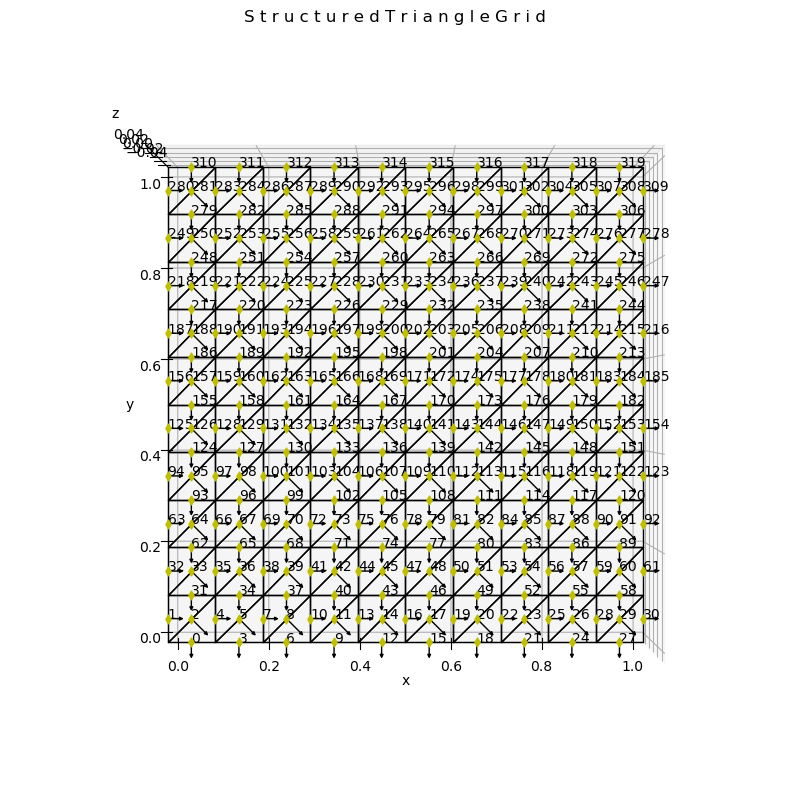

In [5]:
pp.plot_grid(
    bottom_grid,
    fig_size=(10,10),
    alpha=0,
    info='fo'
)

In [6]:
boundary_grid, boundary_face_map, boundary_node_map  = pp.partition.extract_subgrid(subdomain, 
                                                                                    subdomain.face_centers[1, :] == np.max(subdomain.face_centers[1, bottom_face_map]), 
                                                                                    faces=True)

With the following code we set the data, in particular the permeability tensor and the boundary conditions. Since we need to identify each side of $\partial \Omega$ we need few steps.

In [7]:
key = "flow"

In [8]:
top_RT0 = pg.RT0(key)
top_P0 = pg.PwConstants(key)
top_data = {}

top_dof_h =  top_P0.ndof( top_grid )
top_dof_q = top_RT0.ndof( top_grid )

In [9]:
bottom_RT0 = pg.RT0(key)
bottom_P0 = pg.PwConstants(key)
bottom_data = {}

bottom_dof_h = bottom_P0.ndof( bottom_grid )
bottom_dof_q = bottom_RT0.ndof( bottom_grid )

In [10]:
gamma_lagrange = pg.Lagrange1(key)
gamma_data = {}

gamma_dof = gamma_lagrange.ndof( boundary_grid )

In [11]:
# permeability tensor
perm = pp.SecondOrderTensor(np.ones(subdomain.num_cells))
parameters = {
    "second_order_tensor": perm,
}
pp.initialize_data(bottom_grid, bottom_data, key, parameters)
pp.initialize_data(   top_grid,    top_data, key, parameters)

{'discretization_matrices': {'flow': {}},
 'parameters': Data object for physical processes flow
 The keyword "flow" has the following parameters specified: second_order_tensor}

In [12]:
bottom_restrict_boundary = np.zeros(shape = (bottom_dof_q - gamma_dof + 1, bottom_dof_q))
bottom_restrict_boundary[list(range(bottom_dof_q - gamma_dof + 1)), np.where(bottom_grid.face_centers[1,:] < np.max(bottom_grid.face_centers[1,:]))] = 1
bottom_restrict_boundary = sps.csr_matrix(bottom_restrict_boundary)

In [13]:
top_restrict_to_boundary = np.zeros(shape = (top_dof_q, top_dof_q))
tmp = np.where(top_grid.face_centers[1,:] == np.min(top_grid.face_centers[1,:]))
top_restrict_to_boundary[tmp, tmp] = 1
top_restrict_to_boundary = sps.csr_matrix(top_restrict_to_boundary)

In [14]:
map_boundary_top_to_bottom = np.zeros(shape = (bottom_dof_q, top_dof_q))
map_boundary_top_to_bottom[np.where(bottom_grid.face_centers[1,:] == np.max(bottom_grid.face_centers[1,:])), np.where(top_grid.face_centers[1,:] == np.min(top_grid.face_centers[1,:]))] = -1
map_boundary_top_to_bottom = sps.csr_matrix(map_boundary_top_to_bottom)

In [15]:
dirichlet_bottom_flag = bottom_grid.face_centers[1, :] == np.min( bottom_grid.face_centers[1,:] )
dirichlet_bottom_value = lambda t: - top_RT0.assemble_nat_bc(bottom_grid, lambda x: 2, dirichlet_bottom_flag)

neumann_bottom_flag  = np.hstack((np.array(bottom_restrict_boundary @ np.logical_or( bottom_grid.face_centers[0, :] == np.min(bottom_grid.face_centers[0, :]), 
                                                                np.logical_or(
                                                            bottom_grid.face_centers[0, :] == np.max(bottom_grid.face_centers[0, :]), 
                                                            bottom_grid.face_centers[1, :] == np.min(bottom_grid.face_centers[1, :]))  ), dtype=bool), 
                                 np.zeros(shape=bottom_dof_h, dtype=bool)))
neumann_bottom_value = np.zeros(shape=(bottom_dof_h + bottom_dof_q - gamma_dof + 1))

In [16]:
dirichlet_top_flag  = top_grid.face_centers[1, :] == np.max(top_grid.face_centers[1,:])
dirichlet_top_value = lambda t: - top_RT0.assemble_nat_bc(top_grid, lambda x:  max(2 - 2 * t/T, 1), dirichlet_top_flag)

neumann_top_flag  = np.hstack((np.logical_or( top_grid.face_centers[0, :] == np.min(top_grid.face_centers[0, :]), 
                                             top_grid.face_centers[0, :] == np.max(top_grid.face_centers[0, :]) ), 
                                            np.zeros(shape=top_dof_h, dtype=bool)))
neumann_top_value = np.zeros(shape=(top_dof_h + top_dof_q))

In [17]:
neumann_flag = np.hstack( (neumann_bottom_flag, neumann_top_flag) )
neumann_value = np.hstack( (neumann_bottom_value, neumann_top_value) )

Once the data are assigned to the mixed-dimensional grid, we construct the matrices. In particular, the linear system associated with the equation at every timestep is given as
$$
\left(
\begin{array}{cc} 
M_K &     B^\top\\
-\Delta t B  & M_p
\end{array}
\right)
\left(
\begin{array}{c} 
q^{n+1}\\ 
p^{n+1}
\end{array}
\right)
=\left(
\begin{array}{c} 
p_{\partial} + M_p g\\ 
M_p p^n + \Delta t M_p f^{n+1}
\end{array}
\right)
$$<br>
where $p_{\partial}$ is the vector associated to the pressure boundary contions, $(\cdot)^n$ is a generic variable at the n-th time instant. We can now construct the initial building blocks of the monolithic matrix:

In [18]:
top_mass_h =  top_P0.assemble_mass_matrix(top_grid, top_data)
top_mass_q = top_RT0.assemble_mass_matrix(top_grid, top_data)
top_B = - top_mass_h @ pg.div( top_grid )

In [19]:
bottom_mass_h =  bottom_P0.assemble_mass_matrix( bottom_grid, bottom_data )
bottom_mass_q = bottom_RT0.assemble_mass_matrix( bottom_grid, bottom_data )
bottom_B = - bottom_mass_h @ pg.div( bottom_grid )

In [20]:
top_proj_q = top_RT0.eval_at_cell_centers( top_grid )
top_proj_h = top_P0.eval_at_cell_centers( top_grid )

bottom_proj_q = bottom_RT0.eval_at_cell_centers( bottom_grid )
bottom_proj_h = bottom_P0.eval_at_cell_centers( bottom_grid )

In [21]:
# assemble initial solution
initial_solution = np.zeros(top_dof_q + top_dof_h + bottom_dof_q - gamma_dof + 1 + bottom_dof_h)

In [22]:
bottom_q_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_q_mask[:(bottom_dof_q - gamma_dof + 1)] = True
bottom_q_mask[ (bottom_dof_q - gamma_dof + 1 + bottom_dof_h) + np.where(bottom_grid.face_centers[1,:] == np.min(bottom_grid.face_centers[1,:]))[0] ] = True

bottom_h_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_h_mask[ (bottom_dof_q - gamma_dof + 1) : (bottom_dof_q - gamma_dof + 1 + bottom_dof_h) ] = True

top_q_mask = np.zeros_like(initial_solution, dtype=bool)
top_q_mask[(bottom_dof_q - gamma_dof + 1 + bottom_dof_h):(bottom_dof_q - gamma_dof + 1 + bottom_dof_h + top_dof_q)] = True

top_h_mask = np.zeros_like(initial_solution, dtype=bool)
top_h_mask[ (bottom_dof_q - gamma_dof + 1 + bottom_dof_h + top_dof_q) : (bottom_dof_q - gamma_dof + 1 + bottom_dof_h + top_dof_q + top_dof_h) ] = True

In [23]:
initial_solution[top_h_mask]    =    top_P0.interpolate(   top_grid, lambda x: 2)
initial_solution[bottom_h_mask] = bottom_P0.interpolate(bottom_grid, lambda x: 2)

In [24]:
top_saver    = pp.Exporter(top_grid,    "top_sol", folder_name=output_directory)
bottom_saver = pp.Exporter(bottom_grid, "bottom_sol", folder_name=output_directory)

def save_step(current_sol, step):
    ins = list()

    ins.append((top_grid, "cell_q", ( top_proj_q @ current_sol[top_q_mask] ).reshape((3, -1), order="F")))
    ins.append((top_grid, "cell_h", top_proj_h @ current_sol[top_h_mask]))

    top_saver.write_vtu(ins, time_step=step)

    ins = list()

    b_q = current_sol[bottom_q_mask]
    b_q[ (bottom_dof_q - gamma_dof + 1) : ] = -b_q[ (bottom_dof_q - gamma_dof + 1) : ]

    ins.append((bottom_grid, "cell_q", ( bottom_proj_q @ b_q ).reshape((3, -1), order="F")))
    ins.append((bottom_grid, "cell_h", bottom_proj_h @ current_sol[bottom_h_mask]))

    bottom_saver.write_vtu(ins, time_step=step)

In [25]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [26]:
# solve the problem

sol = [initial_solution]

t = 0

save_step(sol[-1], 0)

We need to solve the linear system, PyGeoN provides a framework for that. The actual imposition of essential boundary conditions (flux boundary conditions) might change the symmetry of the global system, the class `pg.LinearSystem` preserves this structure by internally eliminating these degrees of freedom. Once the problem is solved, we extract the two solutions $q$ and $p$.

In [27]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    current_time = step * dt
    
    rhs = np.zeros_like(sol[-1])
    rhs[top_q_mask]    += dirichlet_top_value(current_time)
    rhs[bottom_q_mask] += dirichlet_bottom_value(current_time)

    rhs[top_h_mask]    +=    top_mass_h @ sol[-1][top_h_mask]
    rhs[bottom_h_mask] += bottom_mass_h @ sol[-1][bottom_h_mask]


    spp = sps.bmat(
        [[bottom_restrict_boundary @ bottom_mass_q @ bottom_restrict_boundary.T, bottom_restrict_boundary @ bottom_B.T, bottom_restrict_boundary @ bottom_mass_q @ map_boundary_top_to_bottom @ top_restrict_to_boundary,       None],
         [                          -dt * bottom_B @ bottom_restrict_boundary.T,                         bottom_mass_h,                           -dt * bottom_B @ map_boundary_top_to_bottom @ top_restrict_to_boundary,       None],
         [                                                                 None,                                  None,                                                                                       top_mass_q,    top_B.T],
         [                                                                 None,                                  None,                                                                                      -dt * top_B, top_mass_h]], format = 'csc')
     
    ls = pg.LinearSystem(spp, rhs)
    ls.flag_ess_bc(neumann_flag, neumann_value)

    sol.append( ls.solve() )

    save_step(sol[-1], step)